# Machine Learning Assignment 4: Image Classification using CNN

## Introduction
In this notebook, we will work on image classification using Convolutional Neural Networks (CNN) for the provided dataset.  
The notebook will cover the following major steps:
- Data Exploration
- Modeling with CNN
- Hyperparameter Tuning and Evaluation
- Final Model Inference

## (a) Dataloader

In this part, we will load the MNIST dataset provided as `.npy` files, convert the data into PyTorch tensors, and set up a `DataLoader` to handle batching and shuffling. The `DataLoader` will allow us to feed data efficiently into the CNN model during training.


In [140]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt


torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Load dataset from provided .npy files
x_train = np.load("x_train.npy").reshape(-1, 1, 28, 28)  # Reshape to (N, 1, 28, 28) for CNN input
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy").reshape(-1, 1, 28, 28)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for the data
data_train = TensorDataset(x_train_tensor, y_train_tensor)
data_test = TensorDataset(x_test_tensor)
data_train_loader = DataLoader(data_train, batch_size=64, shuffle=True)
data_test_loader = DataLoader(data_test, batch_size=64, shuffle=False)

print("DataLoader for the full dataset is ready for both training and testing.")

DataLoader for the full dataset is ready for both training and testing.


- The MNIST dataset has been loaded from the provided `.npy` files and converted into PyTorch tensors.
- The data is reshaped to `(N, 1, 28, 28)` format, where `N` is the number of samples, `1` is the channel dimension (for grayscale images), and `28 x 28` is the image size.
- `DataLoader` is created for the entire training and testing dataset with a batch size of 64.

## (b) Data Exploration

Before building our CNN model, we'll perform basic data exploration to understand the structure of the dataset. This involves visualizing a sample image of each digit and counting the number of samples for each class (0-9) in the training dataset.

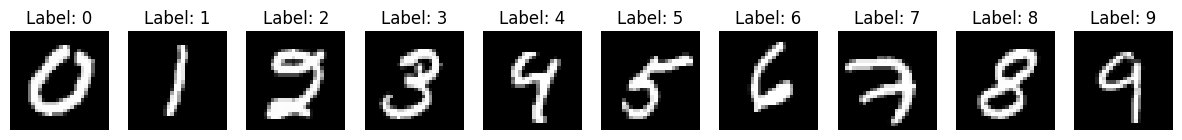

Sample counts for each digit (0-9):
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples

Total sample count =  60000


In [141]:
# Visualize one example of each digit
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
labels_found = set()
for img, label in zip(x_train, y_train):
    if label not in labels_found:
        ax = axes[label]
        ax.imshow(img.reshape(28, 28), cmap="gray")  # Reshape to 28x28 for display
        ax.set_title(f"Label: {label}")
        ax.axis('off')
        labels_found.add(label)
    if len(labels_found) == 10:
        break
plt.show()

# Count the number of samples for each digit
unique, counts = np.unique(y_train, return_counts=True)
digit_counts = dict(zip(unique, counts))
total = 0

print("Sample counts for each digit (0-9):")
for digit, count in digit_counts.items():
    print(f"Digit {digit}: {count} samples")
    total += count
print("\nTotal sample count = ", total)

- The plot above shows one sample image for each digit from 0 to 9 in the dataset.
- The sample counts below the plot display the distribution of each digit in the dataset:
  - We observe that the dataset contains a total of 60,000 samples.
  - Although there is some variation in the sample counts for each digit, the distribution across digits is relatively balanced, so we can expect the model training to be reasonably fair across classes.

## (c) Modeling

### (1) Splitting Training and Validation Data

In this step, we will split the original training dataset of 60,000 samples into a training set (80%) and a validation set (20%). The validation set will help us monitor model performance and tune hyperparameters.


In [142]:
train_size = int(0.8 * len(data_train))
val_size = len(data_train) - train_size

train_data, val_data = random_split(data_train, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

print("Data splitting complete. Training and validation DataLoaders are ready.")

Data splitting complete. Training and validation DataLoaders are ready.


### (2) Visualize the Filter in Each Layer

In this step, we define a Convolutional Neural Network (CNN) model to classify the digits in the dataset. We will then visualize the filters in the convolutional layers to understand what the model learns at each layer.

In [143]:
class CNNModel(nn.Module):
    def __init__(self, num_filters1=16, num_filters2=32, filter_size=3, stride=1, dropout_rate=0.0, activation_fn=nn.ReLU(), num_layers=2):
        super(CNNModel, self).__init__()
        
        self.activation_fn = activation_fn

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, num_filters1, kernel_size=filter_size, stride=stride, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max-pooling layer
        
        # Additional convolutional layers based on num_layers
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=filter_size, stride=1, padding=1) if num_layers > 1 else None
        self.conv3 = nn.Conv2d(num_filters2, num_filters2 * 2, kernel_size=filter_size, stride=1, padding=1) if num_layers > 2 else None

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Dummy input to calculate flattened size after convolutions and pooling
        dummy_input = torch.zeros(1, 1, 28, 28)  # MNIST images are 28x28
        dummy_output = self._forward_conv_layers(dummy_input)
        flattened_size = dummy_output.view(-1).shape[0]

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def _forward_conv_layers(self, x):
        # Apply first convolutional layer
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x)
        
        # Apply additional layers if they exist
        if self.conv2:
            x = self.activation_fn(self.conv2(x))
            x = self.pool(x)
            x = self.dropout(x)
        if self.conv3:
            x = self.activation_fn(self.conv3(x))
            x = self.pool(x)
            x = self.dropout(x)
        
        return x

    def forward(self, x):
        # Forward through convolutional layers
        x = self._forward_conv_layers(x)
        
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.activation_fn(self.fc1(x))
        x = self.fc2(x)
        
        return x

Visualizing filters in the first convolutional layer:


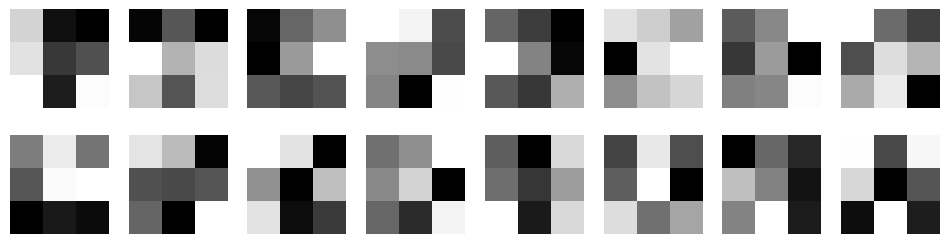

Visualizing filters in the second convolutional layer:


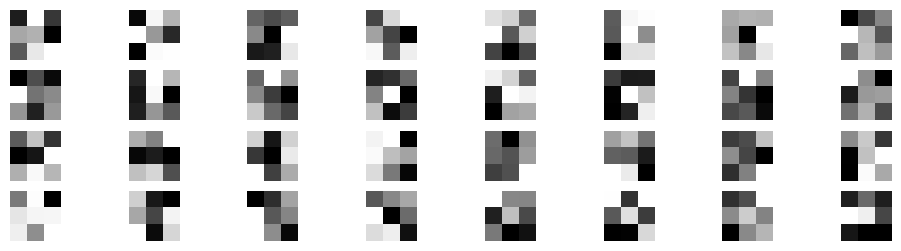

In [144]:
# Visualize filters in the first convolutional layer
def visualize_filters(layer, n_filters):
    # Get the weights of the convolutional layer
    filters = layer.weight.data.clone()
    n_cols = 8
    n_rows = n_filters // n_cols
    # Plot each filter
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3))
    for i, ax in enumerate(axes.flatten()):
        if i < n_filters:
            # Squeeze the filter tensor and plot
            ax.imshow(filters[i, 0].cpu(), cmap='gray')
            ax.axis('off')
    plt.show()

# Instantiate the model
model = CNNModel()

print("Visualizing filters in the first convolutional layer:")
visualize_filters(model.conv1, n_filters=16)

print("Visualizing filters in the second convolutional layer:")
visualize_filters(model.conv2, n_filters=32)


Initially, these filters are randomly initialized, so the patterns they represent won’t be meaningful yet.

### (3) Monitor Training Loss and Report Validation Accuracy

In this part, we train the CNN model on the training data, monitor the loss across epochs, and evaluate the classification accuracy on the validation dataset after each epoch. The training loss will help us understand how well the model is learning from the training data, and the validation accuracy will show how well it generalizes to unseen data.

In [145]:
def train_and_evaluate(model, train_loader, val_loader=None, optimizer=None, scheduler=None, epochs=5):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase with tqdm for progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Update learning rate if a scheduler is provided
        if scheduler:
            scheduler.step()

        # Calculate and store average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase (only if val_loader is provided)
        if val_loader:
            model.eval()  # Set model to evaluation mode
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        else:
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")

    # Return training losses and validation accuracies (if val_accuracies exists)
    return train_losses, val_accuracies if val_loader else train_losses

train_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer=optim.Adam(model.parameters(), lr=0.001), epochs=5)

# Report the overall classification accuracy on the validation dataset
overall_val_accuracy = val_accuracies[-1]
print(f"\nOverall Classification Accuracy on Validation Dataset: {overall_val_accuracy:.4f}")

Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 42.10it/s]


Epoch 1, Training Loss: 0.2673, Validation Accuracy: 0.9695


Epoch 2/5: 100%|██████████| 750/750 [00:15<00:00, 47.24it/s]


Epoch 2, Training Loss: 0.0749, Validation Accuracy: 0.9816


Epoch 3/5: 100%|██████████| 750/750 [00:15<00:00, 48.48it/s]


Epoch 3, Training Loss: 0.0512, Validation Accuracy: 0.9814


Epoch 4/5: 100%|██████████| 750/750 [00:15<00:00, 47.40it/s]


Epoch 4, Training Loss: 0.0384, Validation Accuracy: 0.9852


Epoch 5/5: 100%|██████████| 750/750 [00:15<00:00, 47.77it/s]


Epoch 5, Training Loss: 0.0315, Validation Accuracy: 0.9867

Overall Classification Accuracy on Validation Dataset: 0.9867


- **Training Loss**: The average training loss per epoch indicates how well the model is learning from the training data. A decreasing trend in training loss suggests that the model is optimizing its weights to fit the data better.
- **Validation Accuracy**: The validation accuracy per epoch measures the model’s performance on the validation set. This metric helps assess how well the model generalizes to unseen data.


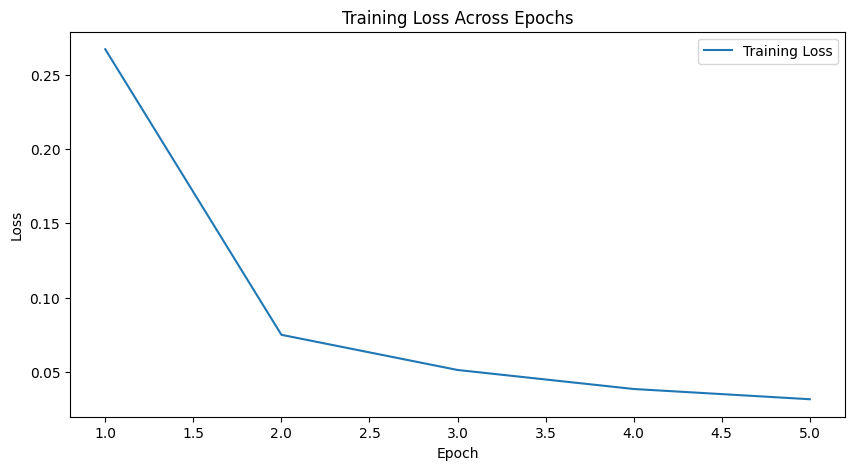

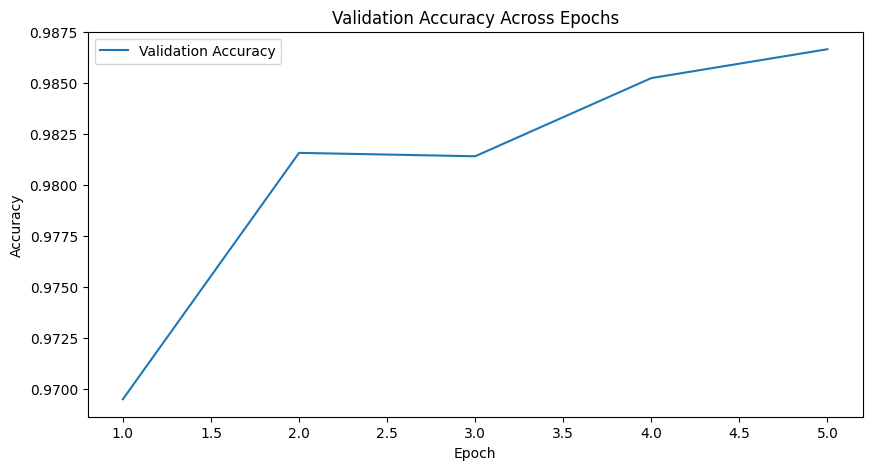

In [146]:
import matplotlib.pyplot as plt

def plot_training_progress(train_losses, val_accuracies, epochs=5):
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Across Epochs')
    plt.legend()
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Across Epochs')
    plt.legend()
    plt.show()

plot_training_progress(train_losses, val_accuracies)

#### Training and Validation Plots

- The **training loss plot** shows the model’s progress over each epoch, ideally decreasing over time as the model learns from the data.
- The **validation accuracy plot** shows the accuracy on the validation dataset. An increasing trend in validation accuracy indicates that the model is improving its generalization performance on unseen data.


### (4) Hyperparameter Tuning

In this part, we experiment with different hyperparameters in the following order:
- **Number of Layers**: We test configurations with 2 or 3 convolutional layers to explore deeper networks.
- **Filter Size**: We use the filter size (3) in the convolutional layers.
- **Stride**: We evaluate strides of 1 and 2 to control the movement of filters across the image.
- **Activation Function**: We experiment with different activation functions (`ReLU` and `LeakyReLU`) to observe their impact on model performance.
- **Dropout Rate**: Different dropout rates (0.2 and 0.5) are tested to regularize the model and prevent overfitting.
- **Weight Decay**: We apply weight regularization (L2) with different values of weight decay to improve generalization.
- **Optimization Method**: We use two different optimizers, Adam and SGD, to optimize the model's performance.

The goal is to identify the configuration that achieves the highest validation accuracy for optimal model performance.


In [147]:
def tune_hyperparameters(train_loader, val_loader, epochs=5):
    best_accuracy = 0
    best_model = None
    best_hyperparameters = {}  # To store the best hyperparameters

    # Hyperparameter choices
    num_layers_choices = [2, 3]                # Number of convolutional layers
    filter_sizes = [3]                         # Filter sizes for convolutional layers
    strides = [1, 2]                              # Strides for convolutional layers
    activation_fns = [nn.ReLU(), nn.LeakyReLU()]  # Activation functions
    dropouts = [0.0, 0.3]                      # Dropout rates for regularization
    weight_decays = [0, 0.01]                  # Weight decay for L2 regularization
    optimizers = ['adam', 'sgd']               # Optimization methods

    for num_layers in num_layers_choices:
        for filter_size in filter_sizes:
            for stride in strides:
                for activation_fn in activation_fns:
                    for dropout in dropouts:
                        for weight_decay in weight_decays:
                            for optimizer_name in optimizers:
                                print(f"\nTesting config: Layers={num_layers}, Filter Size={filter_size}, Stride={stride}, Activation={activation_fn}, Dropout={dropout}, Weight Decay={weight_decay}, Optimizer={optimizer_name}")

                                # Initialize model with current hyperparameters
                                model = CNNModel(
                                    num_filters1=16,  # Fixed number of filters in first conv layer
                                    num_filters2=32,  # Fixed number of filters in second conv layer
                                    filter_size=filter_size,
                                    stride=stride,
                                    dropout_rate=dropout,
                                    activation_fn=activation_fn,
                                    num_layers=num_layers
                                )

                                # Initialize optimizer with weight decay (L2 regularization)
                                if optimizer_name == 'adam':
                                    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
                                elif optimizer_name == 'sgd':
                                    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)

                                # Train and evaluate the model
                                train_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, epochs=epochs)
                                final_accuracy = val_accuracies[-1]

                                # Update the best model if this configuration is better
                                if final_accuracy > best_accuracy:
                                    best_accuracy = final_accuracy
                                    best_model = model

                                    # Save the best hyperparameters
                                    best_hyperparameters = {
                                        "num_layers": num_layers,
                                        "filter_size": filter_size,
                                        "stride": stride,
                                        "dropout_rate": dropout,
                                        "activation_fn": activation_fn,
                                        "weight_decay": weight_decay,
                                        "optimizer": optimizer_name
                                    }

    return best_accuracy, best_model, best_hyperparameters

In [148]:
# Call the hyperparameter tuning function and store the best model and hyperparameters
best_accuracy, best_model, best_hyperparameters = tune_hyperparameters(train_loader, val_loader, epochs=5)


Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 42.66it/s]


Epoch 1, Training Loss: 0.2715, Validation Accuracy: 0.9728


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 39.43it/s]


Epoch 2, Training Loss: 0.0712, Validation Accuracy: 0.9836


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 38.26it/s]


Epoch 3, Training Loss: 0.0516, Validation Accuracy: 0.9856


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.83it/s]


Epoch 4, Training Loss: 0.0395, Validation Accuracy: 0.9875


Epoch 5/5: 100%|██████████| 750/750 [00:17<00:00, 43.34it/s]


Epoch 5, Training Loss: 0.0315, Validation Accuracy: 0.9874

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:16<00:00, 45.34it/s]


Epoch 1, Training Loss: 1.5648, Validation Accuracy: 0.8737


Epoch 2/5: 100%|██████████| 750/750 [00:15<00:00, 48.74it/s]


Epoch 2, Training Loss: 0.3546, Validation Accuracy: 0.9069


Epoch 3/5: 100%|██████████| 750/750 [00:15<00:00, 48.36it/s]


Epoch 3, Training Loss: 0.2517, Validation Accuracy: 0.9296


Epoch 4/5: 100%|██████████| 750/750 [00:15<00:00, 48.83it/s]


Epoch 4, Training Loss: 0.1936, Validation Accuracy: 0.9506


Epoch 5/5: 100%|██████████| 750/750 [00:15<00:00, 49.56it/s]


Epoch 5, Training Loss: 0.1544, Validation Accuracy: 0.9576

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:16<00:00, 46.12it/s]


Epoch 1, Training Loss: 0.3049, Validation Accuracy: 0.9621


Epoch 2/5: 100%|██████████| 750/750 [00:30<00:00, 24.34it/s]


Epoch 2, Training Loss: 0.1398, Validation Accuracy: 0.9571


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 35.98it/s]


Epoch 3, Training Loss: 0.1244, Validation Accuracy: 0.9609


Epoch 4/5: 100%|██████████| 750/750 [00:17<00:00, 42.97it/s]


Epoch 4, Training Loss: 0.1208, Validation Accuracy: 0.9683


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 36.95it/s]


Epoch 5, Training Loss: 0.1163, Validation Accuracy: 0.9700

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 42.03it/s]


Epoch 1, Training Loss: 2.0918, Validation Accuracy: 0.7575


Epoch 2/5: 100%|██████████| 750/750 [00:16<00:00, 45.18it/s]


Epoch 2, Training Loss: 0.4610, Validation Accuracy: 0.8967


Epoch 3/5: 100%|██████████| 750/750 [00:15<00:00, 48.02it/s]


Epoch 3, Training Loss: 0.3023, Validation Accuracy: 0.9191


Epoch 4/5: 100%|██████████| 750/750 [00:15<00:00, 47.10it/s]


Epoch 4, Training Loss: 0.2387, Validation Accuracy: 0.9400


Epoch 5/5: 100%|██████████| 750/750 [00:16<00:00, 45.95it/s]


Epoch 5, Training Loss: 0.1972, Validation Accuracy: 0.9469

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:18<00:00, 41.19it/s]


Epoch 1, Training Loss: 0.2802, Validation Accuracy: 0.9699


Epoch 2/5: 100%|██████████| 750/750 [00:18<00:00, 40.91it/s]


Epoch 2, Training Loss: 0.0941, Validation Accuracy: 0.9828


Epoch 3/5: 100%|██████████| 750/750 [00:17<00:00, 42.92it/s]


Epoch 3, Training Loss: 0.0660, Validation Accuracy: 0.9865


Epoch 4/5: 100%|██████████| 750/750 [00:17<00:00, 43.79it/s]


Epoch 4, Training Loss: 0.0534, Validation Accuracy: 0.9872


Epoch 5/5: 100%|██████████| 750/750 [00:16<00:00, 45.99it/s]


Epoch 5, Training Loss: 0.0465, Validation Accuracy: 0.9893

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:15<00:00, 47.24it/s]


Epoch 1, Training Loss: 1.6428, Validation Accuracy: 0.8426


Epoch 2/5: 100%|██████████| 750/750 [00:17<00:00, 43.00it/s]


Epoch 2, Training Loss: 0.4844, Validation Accuracy: 0.9121


Epoch 3/5: 100%|██████████| 750/750 [00:22<00:00, 33.31it/s]


Epoch 3, Training Loss: 0.3320, Validation Accuracy: 0.9364


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.50it/s]


Epoch 4, Training Loss: 0.2440, Validation Accuracy: 0.9479


Epoch 5/5: 100%|██████████| 750/750 [00:17<00:00, 42.87it/s]


Epoch 5, Training Loss: 0.1969, Validation Accuracy: 0.9590

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:16<00:00, 44.56it/s]


Epoch 1, Training Loss: 0.3380, Validation Accuracy: 0.9607


Epoch 2/5: 100%|██████████| 750/750 [00:17<00:00, 42.81it/s]


Epoch 2, Training Loss: 0.1590, Validation Accuracy: 0.9702


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 38.23it/s]


Epoch 3, Training Loss: 0.1454, Validation Accuracy: 0.9659


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.05it/s]


Epoch 4, Training Loss: 0.1378, Validation Accuracy: 0.9684


Epoch 5/5: 100%|██████████| 750/750 [00:18<00:00, 39.86it/s]


Epoch 5, Training Loss: 0.1371, Validation Accuracy: 0.9708

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:18<00:00, 41.15it/s]


Epoch 1, Training Loss: 1.5600, Validation Accuracy: 0.8597


Epoch 2/5: 100%|██████████| 750/750 [00:18<00:00, 40.40it/s]


Epoch 2, Training Loss: 0.4959, Validation Accuracy: 0.8994


Epoch 3/5: 100%|██████████| 750/750 [00:17<00:00, 41.90it/s]


Epoch 3, Training Loss: 0.3554, Validation Accuracy: 0.9303


Epoch 4/5: 100%|██████████| 750/750 [00:17<00:00, 43.64it/s]


Epoch 4, Training Loss: 0.2743, Validation Accuracy: 0.9451


Epoch 5/5: 100%|██████████| 750/750 [00:17<00:00, 42.71it/s]


Epoch 5, Training Loss: 0.2261, Validation Accuracy: 0.9497

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:18<00:00, 41.35it/s]


Epoch 1, Training Loss: 0.2295, Validation Accuracy: 0.9794


Epoch 2/5: 100%|██████████| 750/750 [00:18<00:00, 40.31it/s]


Epoch 2, Training Loss: 0.0633, Validation Accuracy: 0.9822


Epoch 3/5: 100%|██████████| 750/750 [00:18<00:00, 40.15it/s]


Epoch 3, Training Loss: 0.0424, Validation Accuracy: 0.9876


Epoch 4/5: 100%|██████████| 750/750 [00:16<00:00, 46.68it/s]


Epoch 4, Training Loss: 0.0338, Validation Accuracy: 0.9868


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 39.12it/s]


Epoch 5, Training Loss: 0.0241, Validation Accuracy: 0.9892

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 35.84it/s]


Epoch 1, Training Loss: 1.8263, Validation Accuracy: 0.8557


Epoch 2/5: 100%|██████████| 750/750 [00:22<00:00, 33.46it/s]


Epoch 2, Training Loss: 0.3627, Validation Accuracy: 0.9022


Epoch 3/5: 100%|██████████| 750/750 [00:17<00:00, 42.03it/s]


Epoch 3, Training Loss: 0.2428, Validation Accuracy: 0.9370


Epoch 4/5: 100%|██████████| 750/750 [00:18<00:00, 40.69it/s]


Epoch 4, Training Loss: 0.1850, Validation Accuracy: 0.9518


Epoch 5/5: 100%|██████████| 750/750 [00:16<00:00, 46.59it/s]


Epoch 5, Training Loss: 0.1478, Validation Accuracy: 0.9594

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 43.70it/s]


Epoch 1, Training Loss: 0.3060, Validation Accuracy: 0.9615


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 37.93it/s]


Epoch 2, Training Loss: 0.1402, Validation Accuracy: 0.9539


Epoch 3/5: 100%|██████████| 750/750 [00:18<00:00, 41.38it/s]


Epoch 3, Training Loss: 0.1274, Validation Accuracy: 0.9656


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.48it/s]


Epoch 4, Training Loss: 0.1230, Validation Accuracy: 0.9678


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 39.13it/s]


Epoch 5, Training Loss: 0.1197, Validation Accuracy: 0.9674

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:18<00:00, 40.86it/s]


Epoch 1, Training Loss: 1.5237, Validation Accuracy: 0.8712


Epoch 2/5: 100%|██████████| 750/750 [00:15<00:00, 48.28it/s]


Epoch 2, Training Loss: 0.3597, Validation Accuracy: 0.9083


Epoch 3/5: 100%|██████████| 750/750 [00:15<00:00, 48.89it/s]


Epoch 3, Training Loss: 0.2702, Validation Accuracy: 0.9315


Epoch 4/5: 100%|██████████| 750/750 [00:15<00:00, 48.06it/s]


Epoch 4, Training Loss: 0.2168, Validation Accuracy: 0.9415


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 37.06it/s]


Epoch 5, Training Loss: 0.1819, Validation Accuracy: 0.9465

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 43.79it/s]


Epoch 1, Training Loss: 0.2710, Validation Accuracy: 0.9797


Epoch 2/5: 100%|██████████| 750/750 [00:16<00:00, 46.51it/s]


Epoch 2, Training Loss: 0.0777, Validation Accuracy: 0.9836


Epoch 3/5: 100%|██████████| 750/750 [00:16<00:00, 46.39it/s]


Epoch 3, Training Loss: 0.0572, Validation Accuracy: 0.9875


Epoch 4/5: 100%|██████████| 750/750 [00:16<00:00, 45.82it/s]


Epoch 4, Training Loss: 0.0450, Validation Accuracy: 0.9860


Epoch 5/5: 100%|██████████| 750/750 [00:17<00:00, 44.05it/s]


Epoch 5, Training Loss: 0.0392, Validation Accuracy: 0.9895

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:18<00:00, 41.13it/s]


Epoch 1, Training Loss: 1.6163, Validation Accuracy: 0.8478


Epoch 2/5: 100%|██████████| 750/750 [00:15<00:00, 47.74it/s]


Epoch 2, Training Loss: 0.4710, Validation Accuracy: 0.9078


Epoch 3/5: 100%|██████████| 750/750 [00:15<00:00, 48.69it/s]


Epoch 3, Training Loss: 0.3259, Validation Accuracy: 0.9344


Epoch 4/5: 100%|██████████| 750/750 [00:15<00:00, 49.56it/s]


Epoch 4, Training Loss: 0.2416, Validation Accuracy: 0.9503


Epoch 5/5: 100%|██████████| 750/750 [00:15<00:00, 49.62it/s]


Epoch 5, Training Loss: 0.1928, Validation Accuracy: 0.9597

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:17<00:00, 43.28it/s]


Epoch 1, Training Loss: 0.3225, Validation Accuracy: 0.9581


Epoch 2/5: 100%|██████████| 750/750 [00:18<00:00, 39.95it/s]


Epoch 2, Training Loss: 0.1631, Validation Accuracy: 0.9675


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 39.33it/s]


Epoch 3, Training Loss: 0.1475, Validation Accuracy: 0.9624


Epoch 4/5: 100%|██████████| 750/750 [00:18<00:00, 41.33it/s]


Epoch 4, Training Loss: 0.1405, Validation Accuracy: 0.9662


Epoch 5/5: 100%|██████████| 750/750 [00:16<00:00, 45.62it/s]


Epoch 5, Training Loss: 0.1395, Validation Accuracy: 0.9669

Testing config: Layers=2, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:16<00:00, 45.31it/s]


Epoch 1, Training Loss: 1.6415, Validation Accuracy: 0.8568


Epoch 2/5: 100%|██████████| 750/750 [00:15<00:00, 47.99it/s]


Epoch 2, Training Loss: 0.4782, Validation Accuracy: 0.9005


Epoch 3/5: 100%|██████████| 750/750 [00:16<00:00, 44.80it/s]


Epoch 3, Training Loss: 0.3509, Validation Accuracy: 0.9270


Epoch 4/5: 100%|██████████| 750/750 [00:17<00:00, 43.45it/s]


Epoch 4, Training Loss: 0.2823, Validation Accuracy: 0.9412


Epoch 5/5: 100%|██████████| 750/750 [00:16<00:00, 45.45it/s]


Epoch 5, Training Loss: 0.2336, Validation Accuracy: 0.9493

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 96.76it/s] 


Epoch 1, Training Loss: 0.4064, Validation Accuracy: 0.9515


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 110.34it/s]


Epoch 2, Training Loss: 0.1256, Validation Accuracy: 0.9632


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 111.86it/s]


Epoch 3, Training Loss: 0.0904, Validation Accuracy: 0.9766


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 101.85it/s]


Epoch 4, Training Loss: 0.0757, Validation Accuracy: 0.9781


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 113.63it/s]


Epoch 5, Training Loss: 0.0628, Validation Accuracy: 0.9738

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:05<00:00, 127.23it/s]


Epoch 1, Training Loss: 2.2827, Validation Accuracy: 0.4664


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 117.72it/s]


Epoch 2, Training Loss: 1.6060, Validation Accuracy: 0.8056


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 113.78it/s]


Epoch 3, Training Loss: 0.4747, Validation Accuracy: 0.8855


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 88.74it/s] 


Epoch 4, Training Loss: 0.3233, Validation Accuracy: 0.9122


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 97.61it/s] 


Epoch 5, Training Loss: 0.2624, Validation Accuracy: 0.9248

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:08<00:00, 93.62it/s] 


Epoch 1, Training Loss: 0.4808, Validation Accuracy: 0.9226


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 110.09it/s]


Epoch 2, Training Loss: 0.2025, Validation Accuracy: 0.9447


Epoch 3/5: 100%|██████████| 750/750 [00:08<00:00, 86.52it/s]


Epoch 3, Training Loss: 0.1736, Validation Accuracy: 0.9542


Epoch 4/5: 100%|██████████| 750/750 [00:09<00:00, 78.74it/s] 


Epoch 4, Training Loss: 0.1607, Validation Accuracy: 0.9600


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 87.06it/s]


Epoch 5, Training Loss: 0.1555, Validation Accuracy: 0.9540

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 103.20it/s]


Epoch 1, Training Loss: 2.2860, Validation Accuracy: 0.3662


Epoch 2/5: 100%|██████████| 750/750 [00:08<00:00, 92.02it/s] 


Epoch 2, Training Loss: 1.8068, Validation Accuracy: 0.7573


Epoch 3/5: 100%|██████████| 750/750 [00:08<00:00, 87.13it/s] 


Epoch 3, Training Loss: 0.5842, Validation Accuracy: 0.8675


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 114.36it/s]


Epoch 4, Training Loss: 0.3883, Validation Accuracy: 0.8941


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 101.90it/s]


Epoch 5, Training Loss: 0.3219, Validation Accuracy: 0.9120

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:09<00:00, 80.07it/s] 


Epoch 1, Training Loss: 0.5543, Validation Accuracy: 0.9403


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 106.38it/s]


Epoch 2, Training Loss: 0.1906, Validation Accuracy: 0.9673


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 94.30it/s] 


Epoch 3, Training Loss: 0.1424, Validation Accuracy: 0.9748


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 106.83it/s]


Epoch 4, Training Loss: 0.1240, Validation Accuracy: 0.9762


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 102.17it/s]


Epoch 5, Training Loss: 0.1077, Validation Accuracy: 0.9792

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 103.45it/s]


Epoch 1, Training Loss: 2.2807, Validation Accuracy: 0.5287


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 108.24it/s]


Epoch 2, Training Loss: 1.6580, Validation Accuracy: 0.8013


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 106.89it/s]


Epoch 3, Training Loss: 0.6657, Validation Accuracy: 0.8856


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 102.09it/s]


Epoch 4, Training Loss: 0.4555, Validation Accuracy: 0.9090


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 118.19it/s]


Epoch 5, Training Loss: 0.3788, Validation Accuracy: 0.9187

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 100.51it/s]


Epoch 1, Training Loss: 0.5904, Validation Accuracy: 0.9297


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 108.80it/s]


Epoch 2, Training Loss: 0.2896, Validation Accuracy: 0.9453


Epoch 3/5: 100%|██████████| 750/750 [00:09<00:00, 83.22it/s]


Epoch 3, Training Loss: 0.2489, Validation Accuracy: 0.9508


Epoch 4/5: 100%|██████████| 750/750 [00:11<00:00, 64.44it/s]


Epoch 4, Training Loss: 0.2348, Validation Accuracy: 0.9572


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 84.57it/s] 


Epoch 5, Training Loss: 0.2259, Validation Accuracy: 0.9507

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 101.71it/s]


Epoch 1, Training Loss: 2.2813, Validation Accuracy: 0.5857


Epoch 2/5: 100%|██████████| 750/750 [00:08<00:00, 89.26it/s] 


Epoch 2, Training Loss: 1.6930, Validation Accuracy: 0.7768


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 115.68it/s]


Epoch 3, Training Loss: 0.6963, Validation Accuracy: 0.8811


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 116.64it/s]


Epoch 4, Training Loss: 0.4925, Validation Accuracy: 0.9005


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 116.54it/s]


Epoch 5, Training Loss: 0.4213, Validation Accuracy: 0.9083

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 109.96it/s]


Epoch 1, Training Loss: 0.3967, Validation Accuracy: 0.9457


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 110.93it/s]


Epoch 2, Training Loss: 0.1161, Validation Accuracy: 0.9685


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 110.46it/s]


Epoch 3, Training Loss: 0.0850, Validation Accuracy: 0.9761


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 110.15it/s]


Epoch 4, Training Loss: 0.0710, Validation Accuracy: 0.9778


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 110.43it/s]


Epoch 5, Training Loss: 0.0598, Validation Accuracy: 0.9796

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 119.89it/s]


Epoch 1, Training Loss: 2.2684, Validation Accuracy: 0.5467


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 120.70it/s]


Epoch 2, Training Loss: 1.2521, Validation Accuracy: 0.8404


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 117.24it/s]


Epoch 3, Training Loss: 0.4313, Validation Accuracy: 0.8953


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 119.79it/s]


Epoch 4, Training Loss: 0.3128, Validation Accuracy: 0.9077


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 120.33it/s]


Epoch 5, Training Loss: 0.2570, Validation Accuracy: 0.9253

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 106.82it/s]


Epoch 1, Training Loss: 0.4911, Validation Accuracy: 0.9083


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 108.14it/s]


Epoch 2, Training Loss: 0.2136, Validation Accuracy: 0.9425


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 104.48it/s]


Epoch 3, Training Loss: 0.1824, Validation Accuracy: 0.9519


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 110.03it/s]


Epoch 4, Training Loss: 0.1651, Validation Accuracy: 0.9474


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 102.01it/s]


Epoch 5, Training Loss: 0.1578, Validation Accuracy: 0.9554

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 117.32it/s]


Epoch 1, Training Loss: 2.1954, Validation Accuracy: 0.5555


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 119.92it/s]


Epoch 2, Training Loss: 0.8659, Validation Accuracy: 0.8612


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 118.82it/s]


Epoch 3, Training Loss: 0.4041, Validation Accuracy: 0.8929


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 116.96it/s]


Epoch 4, Training Loss: 0.3243, Validation Accuracy: 0.9095


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 119.00it/s]


Epoch 5, Training Loss: 0.2824, Validation Accuracy: 0.9160

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 108.76it/s]


Epoch 1, Training Loss: 0.4671, Validation Accuracy: 0.9568


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 106.85it/s]


Epoch 2, Training Loss: 0.1615, Validation Accuracy: 0.9709


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 109.02it/s]


Epoch 3, Training Loss: 0.1222, Validation Accuracy: 0.9747


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 105.97it/s]


Epoch 4, Training Loss: 0.1045, Validation Accuracy: 0.9799


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 108.86it/s]


Epoch 5, Training Loss: 0.0921, Validation Accuracy: 0.9816

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 119.16it/s]


Epoch 1, Training Loss: 2.2706, Validation Accuracy: 0.4107


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 116.62it/s]


Epoch 2, Training Loss: 1.4513, Validation Accuracy: 0.7977


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 118.22it/s]


Epoch 3, Training Loss: 0.6685, Validation Accuracy: 0.8852


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 118.15it/s]


Epoch 4, Training Loss: 0.4609, Validation Accuracy: 0.9076


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 115.08it/s]


Epoch 5, Training Loss: 0.3836, Validation Accuracy: 0.9195

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 107.01it/s]


Epoch 1, Training Loss: 0.5456, Validation Accuracy: 0.9373


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 105.56it/s]


Epoch 2, Training Loss: 0.2608, Validation Accuracy: 0.9461


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 104.35it/s]


Epoch 3, Training Loss: 0.2384, Validation Accuracy: 0.9505


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 106.47it/s]


Epoch 4, Training Loss: 0.2272, Validation Accuracy: 0.9565


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 106.41it/s]


Epoch 5, Training Loss: 0.2206, Validation Accuracy: 0.9543

Testing config: Layers=2, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 114.14it/s]


Epoch 1, Training Loss: 2.2767, Validation Accuracy: 0.4584


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 110.51it/s]


Epoch 2, Training Loss: 1.7177, Validation Accuracy: 0.7629


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 115.10it/s]


Epoch 3, Training Loss: 0.7456, Validation Accuracy: 0.8737


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 113.46it/s]


Epoch 4, Training Loss: 0.5154, Validation Accuracy: 0.8951


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 115.69it/s]


Epoch 5, Training Loss: 0.4278, Validation Accuracy: 0.9091

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 37.31it/s]


Epoch 1, Training Loss: 0.2832, Validation Accuracy: 0.9742


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 35.85it/s]


Epoch 2, Training Loss: 0.0696, Validation Accuracy: 0.9832


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 37.16it/s]


Epoch 3, Training Loss: 0.0479, Validation Accuracy: 0.9860


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.83it/s]


Epoch 4, Training Loss: 0.0357, Validation Accuracy: 0.9873


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 37.27it/s]


Epoch 5, Training Loss: 0.0299, Validation Accuracy: 0.9884

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:19<00:00, 39.10it/s]


Epoch 1, Training Loss: 2.2430, Validation Accuracy: 0.5548


Epoch 2/5: 100%|██████████| 750/750 [00:18<00:00, 39.51it/s]


Epoch 2, Training Loss: 0.6491, Validation Accuracy: 0.9097


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 38.85it/s]


Epoch 3, Training Loss: 0.2434, Validation Accuracy: 0.9470


Epoch 4/5: 100%|██████████| 750/750 [00:19<00:00, 38.76it/s]


Epoch 4, Training Loss: 0.1605, Validation Accuracy: 0.9621


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 39.04it/s]


Epoch 5, Training Loss: 0.1268, Validation Accuracy: 0.9654

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 37.03it/s]


Epoch 1, Training Loss: 0.3597, Validation Accuracy: 0.9574


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.92it/s]


Epoch 2, Training Loss: 0.1351, Validation Accuracy: 0.9702


Epoch 3/5: 100%|██████████| 750/750 [00:22<00:00, 33.65it/s]


Epoch 3, Training Loss: 0.1175, Validation Accuracy: 0.9698


Epoch 4/5: 100%|██████████| 750/750 [00:23<00:00, 31.90it/s]


Epoch 4, Training Loss: 0.1103, Validation Accuracy: 0.9640


Epoch 5/5: 100%|██████████| 750/750 [00:21<00:00, 35.64it/s]


Epoch 5, Training Loss: 0.1060, Validation Accuracy: 0.9719

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:21<00:00, 35.49it/s]


Epoch 1, Training Loss: 2.2903, Validation Accuracy: 0.3576


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.73it/s]


Epoch 2, Training Loss: 1.6642, Validation Accuracy: 0.7907


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 38.43it/s]


Epoch 3, Training Loss: 0.4040, Validation Accuracy: 0.9063


Epoch 4/5: 100%|██████████| 750/750 [00:19<00:00, 38.56it/s]


Epoch 4, Training Loss: 0.2476, Validation Accuracy: 0.9202


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 38.29it/s]


Epoch 5, Training Loss: 0.1906, Validation Accuracy: 0.9513

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 36.85it/s]


Epoch 1, Training Loss: 0.3616, Validation Accuracy: 0.9713


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.39it/s]


Epoch 2, Training Loss: 0.1229, Validation Accuracy: 0.9815


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 36.26it/s]


Epoch 3, Training Loss: 0.0898, Validation Accuracy: 0.9828


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.25it/s]


Epoch 4, Training Loss: 0.0752, Validation Accuracy: 0.9887


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 36.33it/s]


Epoch 5, Training Loss: 0.0656, Validation Accuracy: 0.9865

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:19<00:00, 38.09it/s]


Epoch 1, Training Loss: 2.2989, Validation Accuracy: 0.1116


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 37.81it/s]


Epoch 2, Training Loss: 2.1869, Validation Accuracy: 0.6158


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 37.94it/s]


Epoch 3, Training Loss: 0.9728, Validation Accuracy: 0.8633


Epoch 4/5: 100%|██████████| 750/750 [00:19<00:00, 38.04it/s]


Epoch 4, Training Loss: 0.5119, Validation Accuracy: 0.9277


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 38.17it/s]


Epoch 5, Training Loss: 0.3321, Validation Accuracy: 0.9467

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 36.32it/s]


Epoch 1, Training Loss: 0.4661, Validation Accuracy: 0.9533


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.42it/s]


Epoch 2, Training Loss: 0.1838, Validation Accuracy: 0.9591


Epoch 3/5: 100%|██████████| 750/750 [00:21<00:00, 34.62it/s]


Epoch 3, Training Loss: 0.1668, Validation Accuracy: 0.9695


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 35.87it/s]


Epoch 4, Training Loss: 0.1580, Validation Accuracy: 0.9739


Epoch 5/5: 100%|██████████| 750/750 [00:21<00:00, 35.20it/s]


Epoch 5, Training Loss: 0.1525, Validation Accuracy: 0.9759

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 37.48it/s]


Epoch 1, Training Loss: 2.2729, Validation Accuracy: 0.4006


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 37.63it/s]


Epoch 2, Training Loss: 1.2095, Validation Accuracy: 0.8161


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 37.84it/s]


Epoch 3, Training Loss: 0.5893, Validation Accuracy: 0.9073


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 37.35it/s]


Epoch 4, Training Loss: 0.3888, Validation Accuracy: 0.9406


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 37.71it/s]


Epoch 5, Training Loss: 0.2949, Validation Accuracy: 0.9514

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 36.80it/s]


Epoch 1, Training Loss: 0.2618, Validation Accuracy: 0.9792


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.79it/s]


Epoch 2, Training Loss: 0.0650, Validation Accuracy: 0.9819


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 36.83it/s]


Epoch 3, Training Loss: 0.0419, Validation Accuracy: 0.9868


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.50it/s]


Epoch 4, Training Loss: 0.0343, Validation Accuracy: 0.9855


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 36.75it/s]


Epoch 5, Training Loss: 0.0264, Validation Accuracy: 0.9897

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:19<00:00, 38.39it/s]


Epoch 1, Training Loss: 2.2866, Validation Accuracy: 0.3985


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 38.42it/s]


Epoch 2, Training Loss: 1.2675, Validation Accuracy: 0.8598


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 38.50it/s]


Epoch 3, Training Loss: 0.3196, Validation Accuracy: 0.9186


Epoch 4/5: 100%|██████████| 750/750 [00:19<00:00, 38.46it/s]


Epoch 4, Training Loss: 0.1972, Validation Accuracy: 0.9508


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 38.66it/s]


Epoch 5, Training Loss: 0.1487, Validation Accuracy: 0.9627

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 36.82it/s]


Epoch 1, Training Loss: 0.3507, Validation Accuracy: 0.9586


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.79it/s]


Epoch 2, Training Loss: 0.1318, Validation Accuracy: 0.9695


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 36.63it/s]


Epoch 3, Training Loss: 0.1180, Validation Accuracy: 0.9742


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.68it/s]


Epoch 4, Training Loss: 0.1079, Validation Accuracy: 0.9664


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 37.01it/s]


Epoch 5, Training Loss: 0.1062, Validation Accuracy: 0.9660

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:19<00:00, 37.99it/s]


Epoch 1, Training Loss: 2.2989, Validation Accuracy: 0.1103


Epoch 2/5: 100%|██████████| 750/750 [00:19<00:00, 37.76it/s]


Epoch 2, Training Loss: 2.2842, Validation Accuracy: 0.3141


Epoch 3/5: 100%|██████████| 750/750 [00:19<00:00, 37.89it/s]


Epoch 3, Training Loss: 1.5746, Validation Accuracy: 0.8326


Epoch 4/5: 100%|██████████| 750/750 [00:19<00:00, 37.62it/s]


Epoch 4, Training Loss: 0.4201, Validation Accuracy: 0.8989


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 36.50it/s]


Epoch 5, Training Loss: 0.2674, Validation Accuracy: 0.9234

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 35.97it/s]


Epoch 1, Training Loss: 0.3479, Validation Accuracy: 0.9738


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 35.84it/s]


Epoch 2, Training Loss: 0.1024, Validation Accuracy: 0.9852


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 35.95it/s]


Epoch 3, Training Loss: 0.0785, Validation Accuracy: 0.9874


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 35.98it/s]


Epoch 4, Training Loss: 0.0663, Validation Accuracy: 0.9894


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 35.72it/s]


Epoch 5, Training Loss: 0.0541, Validation Accuracy: 0.9900

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 37.36it/s]


Epoch 1, Training Loss: 2.2863, Validation Accuracy: 0.4725


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 37.28it/s]


Epoch 2, Training Loss: 1.4718, Validation Accuracy: 0.8252


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 37.16it/s]


Epoch 3, Training Loss: 0.5822, Validation Accuracy: 0.9167


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 37.37it/s]


Epoch 4, Training Loss: 0.3356, Validation Accuracy: 0.9453


Epoch 5/5: 100%|██████████| 750/750 [00:19<00:00, 37.63it/s]


Epoch 5, Training Loss: 0.2577, Validation Accuracy: 0.9544

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 35.99it/s]


Epoch 1, Training Loss: 0.4469, Validation Accuracy: 0.9655


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 35.76it/s]


Epoch 2, Training Loss: 0.1913, Validation Accuracy: 0.9680


Epoch 3/5: 100%|██████████| 750/750 [00:22<00:00, 33.42it/s]


Epoch 3, Training Loss: 0.1682, Validation Accuracy: 0.9673


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.06it/s]


Epoch 4, Training Loss: 0.1581, Validation Accuracy: 0.9690


Epoch 5/5: 100%|██████████| 750/750 [00:21<00:00, 35.46it/s]


Epoch 5, Training Loss: 0.1553, Validation Accuracy: 0.9681

Testing config: Layers=3, Filter Size=3, Stride=1, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:20<00:00, 36.99it/s]


Epoch 1, Training Loss: 2.2969, Validation Accuracy: 0.3597


Epoch 2/5: 100%|██████████| 750/750 [00:20<00:00, 36.89it/s]


Epoch 2, Training Loss: 2.0890, Validation Accuracy: 0.6947


Epoch 3/5: 100%|██████████| 750/750 [00:20<00:00, 37.21it/s]


Epoch 3, Training Loss: 0.8345, Validation Accuracy: 0.8817


Epoch 4/5: 100%|██████████| 750/750 [00:20<00:00, 36.97it/s]


Epoch 4, Training Loss: 0.4469, Validation Accuracy: 0.9340


Epoch 5/5: 100%|██████████| 750/750 [00:20<00:00, 37.07it/s]


Epoch 5, Training Loss: 0.3178, Validation Accuracy: 0.9457

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:08<00:00, 89.05it/s]


Epoch 1, Training Loss: 0.5030, Validation Accuracy: 0.9513


Epoch 2/5: 100%|██████████| 750/750 [00:08<00:00, 89.23it/s]


Epoch 2, Training Loss: 0.1227, Validation Accuracy: 0.9728


Epoch 3/5: 100%|██████████| 750/750 [00:08<00:00, 88.89it/s]


Epoch 3, Training Loss: 0.0893, Validation Accuracy: 0.9771


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 89.04it/s]


Epoch 4, Training Loss: 0.0710, Validation Accuracy: 0.9827


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 88.48it/s]


Epoch 5, Training Loss: 0.0608, Validation Accuracy: 0.9797

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 102.12it/s]


Epoch 1, Training Loss: 2.2945, Validation Accuracy: 0.3220


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 99.99it/s] 


Epoch 2, Training Loss: 2.2146, Validation Accuracy: 0.4170


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 100.81it/s]


Epoch 3, Training Loss: 1.0590, Validation Accuracy: 0.8111


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 101.35it/s]


Epoch 4, Training Loss: 0.4576, Validation Accuracy: 0.8924


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 103.73it/s]


Epoch 5, Training Loss: 0.3176, Validation Accuracy: 0.9139

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 95.16it/s] 


Epoch 1, Training Loss: 0.6882, Validation Accuracy: 0.9136


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 96.66it/s] 


Epoch 2, Training Loss: 0.2374, Validation Accuracy: 0.9351


Epoch 3/5: 100%|██████████| 750/750 [00:08<00:00, 93.42it/s]


Epoch 3, Training Loss: 0.1912, Validation Accuracy: 0.9489


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 87.95it/s]


Epoch 4, Training Loss: 0.1699, Validation Accuracy: 0.9572


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 93.32it/s]


Epoch 5, Training Loss: 0.1591, Validation Accuracy: 0.9573

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 106.12it/s]


Epoch 1, Training Loss: 2.2972, Validation Accuracy: 0.2209


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 107.08it/s]


Epoch 2, Training Loss: 2.2665, Validation Accuracy: 0.2435


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 106.75it/s]


Epoch 3, Training Loss: 1.7599, Validation Accuracy: 0.6088


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 108.80it/s]


Epoch 4, Training Loss: 0.8369, Validation Accuracy: 0.8120


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 108.81it/s]


Epoch 5, Training Loss: 0.5309, Validation Accuracy: 0.8667

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:08<00:00, 92.65it/s] 


Epoch 1, Training Loss: 0.7048, Validation Accuracy: 0.9468


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 94.66it/s]


Epoch 2, Training Loss: 0.2541, Validation Accuracy: 0.9652


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 93.89it/s]


Epoch 3, Training Loss: 0.1983, Validation Accuracy: 0.9728


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 91.96it/s]


Epoch 4, Training Loss: 0.1684, Validation Accuracy: 0.9743


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 93.41it/s]


Epoch 5, Training Loss: 0.1502, Validation Accuracy: 0.9794

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 105.91it/s]


Epoch 1, Training Loss: 2.2988, Validation Accuracy: 0.1488


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 105.55it/s]


Epoch 2, Training Loss: 2.2833, Validation Accuracy: 0.2192


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 105.97it/s]


Epoch 3, Training Loss: 2.1294, Validation Accuracy: 0.4542


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 104.60it/s]


Epoch 4, Training Loss: 1.4743, Validation Accuracy: 0.6989


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 105.19it/s]


Epoch 5, Training Loss: 0.9783, Validation Accuracy: 0.8336

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 93.91it/s]


Epoch 1, Training Loss: 1.1716, Validation Accuracy: 0.8823


Epoch 2/5: 100%|██████████| 750/750 [00:08<00:00, 92.49it/s]


Epoch 2, Training Loss: 0.4725, Validation Accuracy: 0.9103


Epoch 3/5: 100%|██████████| 750/750 [00:09<00:00, 80.12it/s]


Epoch 3, Training Loss: 0.3853, Validation Accuracy: 0.9396


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 85.79it/s]


Epoch 4, Training Loss: 0.3494, Validation Accuracy: 0.9469


Epoch 5/5: 100%|██████████| 750/750 [00:09<00:00, 82.83it/s]


Epoch 5, Training Loss: 0.3232, Validation Accuracy: 0.9467

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=ReLU(), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 105.00it/s]


Epoch 1, Training Loss: 2.3009, Validation Accuracy: 0.1103


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 103.38it/s]


Epoch 2, Training Loss: 2.2989, Validation Accuracy: 0.1103


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 105.15it/s]


Epoch 3, Training Loss: 2.2972, Validation Accuracy: 0.1103


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 105.73it/s]


Epoch 4, Training Loss: 2.2935, Validation Accuracy: 0.1615


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 104.25it/s]


Epoch 5, Training Loss: 2.2819, Validation Accuracy: 0.2057

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 98.09it/s] 


Epoch 1, Training Loss: 0.4213, Validation Accuracy: 0.9597


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 97.00it/s] 


Epoch 2, Training Loss: 0.1166, Validation Accuracy: 0.9686


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 94.90it/s] 


Epoch 3, Training Loss: 0.0843, Validation Accuracy: 0.9753


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 97.52it/s] 


Epoch 4, Training Loss: 0.0714, Validation Accuracy: 0.9768


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 98.09it/s] 


Epoch 5, Training Loss: 0.0583, Validation Accuracy: 0.9793

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 107.59it/s]


Epoch 1, Training Loss: 2.2975, Validation Accuracy: 0.1103


Epoch 2/5: 100%|██████████| 750/750 [00:06<00:00, 107.96it/s]


Epoch 2, Training Loss: 2.2605, Validation Accuracy: 0.4815


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 109.34it/s]


Epoch 3, Training Loss: 1.5428, Validation Accuracy: 0.7385


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 106.94it/s]


Epoch 4, Training Loss: 0.6127, Validation Accuracy: 0.8510


Epoch 5/5: 100%|██████████| 750/750 [00:06<00:00, 108.98it/s]


Epoch 5, Training Loss: 0.3887, Validation Accuracy: 0.8968

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 97.42it/s] 


Epoch 1, Training Loss: 0.6162, Validation Accuracy: 0.9019


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 94.70it/s] 


Epoch 2, Training Loss: 0.2347, Validation Accuracy: 0.9413


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 96.51it/s] 


Epoch 3, Training Loss: 0.1941, Validation Accuracy: 0.9486


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 95.14it/s] 


Epoch 4, Training Loss: 0.1725, Validation Accuracy: 0.9527


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 95.13it/s]


Epoch 5, Training Loss: 0.1623, Validation Accuracy: 0.9587

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.0, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:06<00:00, 108.82it/s]


Epoch 1, Training Loss: 2.2975, Validation Accuracy: 0.1993


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 105.18it/s]


Epoch 2, Training Loss: 2.2834, Validation Accuracy: 0.1991


Epoch 3/5: 100%|██████████| 750/750 [00:06<00:00, 108.01it/s]


Epoch 3, Training Loss: 2.1732, Validation Accuracy: 0.4262


Epoch 4/5: 100%|██████████| 750/750 [00:06<00:00, 108.02it/s]


Epoch 4, Training Loss: 1.1940, Validation Accuracy: 0.7594


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 105.63it/s]


Epoch 5, Training Loss: 0.5766, Validation Accuracy: 0.8562

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 95.71it/s]


Epoch 1, Training Loss: 0.6701, Validation Accuracy: 0.9511


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 95.93it/s] 


Epoch 2, Training Loss: 0.2341, Validation Accuracy: 0.9657


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 95.28it/s] 


Epoch 3, Training Loss: 0.1785, Validation Accuracy: 0.9735


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 95.02it/s] 


Epoch 4, Training Loss: 0.1559, Validation Accuracy: 0.9774


Epoch 5/5: 100%|██████████| 750/750 [00:08<00:00, 93.48it/s] 


Epoch 5, Training Loss: 0.1367, Validation Accuracy: 0.9788

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 104.61it/s]


Epoch 1, Training Loss: 2.3027, Validation Accuracy: 0.1546


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 105.39it/s]


Epoch 2, Training Loss: 2.2956, Validation Accuracy: 0.1247


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 104.27it/s]


Epoch 3, Training Loss: 2.2776, Validation Accuracy: 0.3333


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 104.77it/s]


Epoch 4, Training Loss: 2.0830, Validation Accuracy: 0.5560


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 104.65it/s]


Epoch 5, Training Loss: 1.2952, Validation Accuracy: 0.7919

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=adam


Epoch 1/5: 100%|██████████| 750/750 [00:08<00:00, 92.57it/s]


Epoch 1, Training Loss: 0.9952, Validation Accuracy: 0.8942


Epoch 2/5: 100%|██████████| 750/750 [00:08<00:00, 93.68it/s]


Epoch 2, Training Loss: 0.4016, Validation Accuracy: 0.9449


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 94.98it/s]


Epoch 3, Training Loss: 0.3331, Validation Accuracy: 0.9507


Epoch 4/5: 100%|██████████| 750/750 [00:08<00:00, 92.94it/s]


Epoch 4, Training Loss: 0.3012, Validation Accuracy: 0.9525


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 94.12it/s]


Epoch 5, Training Loss: 0.2888, Validation Accuracy: 0.9504

Testing config: Layers=3, Filter Size=3, Stride=2, Activation=LeakyReLU(negative_slope=0.01), Dropout=0.3, Weight Decay=0.01, Optimizer=sgd


Epoch 1/5: 100%|██████████| 750/750 [00:07<00:00, 103.21it/s]


Epoch 1, Training Loss: 2.3019, Validation Accuracy: 0.1103


Epoch 2/5: 100%|██████████| 750/750 [00:07<00:00, 101.72it/s]


Epoch 2, Training Loss: 2.2984, Validation Accuracy: 0.1103


Epoch 3/5: 100%|██████████| 750/750 [00:07<00:00, 104.74it/s]


Epoch 3, Training Loss: 2.2947, Validation Accuracy: 0.1727


Epoch 4/5: 100%|██████████| 750/750 [00:07<00:00, 104.08it/s]


Epoch 4, Training Loss: 2.2817, Validation Accuracy: 0.2012


Epoch 5/5: 100%|██████████| 750/750 [00:07<00:00, 102.11it/s]


Epoch 5, Training Loss: 2.1931, Validation Accuracy: 0.2771


In [149]:
print(f'Best Validation Accuracy: {best_accuracy:.4f}')
print("\nBest Hyperparameters Found:")
for key, value in best_hyperparameters.items():
    print(f"  {key}: {value}")

Best Validation Accuracy: 0.9900

Best Hyperparameters Found:
  num_layers: 3
  filter_size: 3
  stride: 1
  dropout_rate: 0.3
  activation_fn: LeakyReLU(negative_slope=0.01)
  weight_decay: 0
  optimizer: adam


### (5) Inference on test dataset and comparison of classification accuracy before in step (3) and after hyperparameter tuning

In this section, we compare the overall validation accuracy achieved by the model before and after hyperparameter tuning:

1. **Validation Accuracy Before Tuning**: The initial model in Part (3) achieved an overall validation accuracy of `0.9867`.

2. **Validation Accuracy After Tuning**: Using hyperparameter tuning, we optimized the CNN model's architecture and training parameters. The best validation accuracy achieved during the tuning process was printed after tuning which was `0.9900`.

This comparison demonstrates the impact of hyperparameter tuning on model performance, with the aim of achieving improved accuracy and better generalization on the validation dataset. The tuning process allowed us to experiment with different configurations, resulting in a more robust model.

After identifying the best hyperparameters through tuning, we will now re-train the CNN model on the entire training dataset using the optimal configuration to provide inference on the test dataset. The best hyperparameters found were:

- **Number of Layers**: `best_hyperparameters["num_layers"] = 3`
- **Filter Size**: `best_hyperparameters["filter_size"] = 3`
- **Stride**: `best_hyperparameters["stride"] = 1`
- **Dropout Rate**: `best_hyperparameters["dropout_rate"] = 0.3`
- **Activation Function**: `best_hyperparameters["activation_fn"] = LeakyReLU(negative_slope=0.01)`
- **Weight Decay**: `best_hyperparameters["weight_decay"] = 0`
- **Optimizer**: `best_hyperparameters["optimizer"] = adam`

In [152]:
# Reinitialize the model with the best hyperparameters
final_model = CNNModel(
    num_filters1=16,  # Fixed number of filters in the first conv layer
    num_filters2=32,  # Fixed number of filters in the second conv layer
    filter_size=best_hyperparameters["filter_size"],
    stride=best_hyperparameters["stride"],
    dropout_rate=best_hyperparameters["dropout_rate"],
    activation_fn=best_hyperparameters["activation_fn"],
    num_layers=best_hyperparameters["num_layers"]
)

# Choose the best optimizer based on tuning results
if best_hyperparameters["optimizer"] == "adam":
    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001, weight_decay=best_hyperparameters["weight_decay"])
elif best_hyperparameters["optimizer"] == "sgd":
    final_optimizer = torch.optim.SGD(final_model.parameters(), lr=0.001, momentum=0.9, weight_decay=best_hyperparameters["weight_decay"])

# Train the final model on the full training dataset
train_losses = train_and_evaluate(final_model, data_train_loader, val_loader=None, optimizer=final_optimizer, epochs=25)

Epoch 1/25: 100%|██████████| 938/938 [00:20<00:00, 44.67it/s]


Epoch 1, Training Loss: 0.3265


Epoch 2/25: 100%|██████████| 938/938 [00:23<00:00, 39.37it/s]


Epoch 2, Training Loss: 0.0932


Epoch 3/25: 100%|██████████| 938/938 [00:25<00:00, 37.41it/s]


Epoch 3, Training Loss: 0.0731


Epoch 4/25: 100%|██████████| 938/938 [00:28<00:00, 32.59it/s]


Epoch 4, Training Loss: 0.0608


Epoch 5/25: 100%|██████████| 938/938 [00:27<00:00, 34.39it/s]


Epoch 5, Training Loss: 0.0515


Epoch 6/25: 100%|██████████| 938/938 [00:24<00:00, 38.59it/s]


Epoch 6, Training Loss: 0.0458


Epoch 7/25: 100%|██████████| 938/938 [00:23<00:00, 39.53it/s]


Epoch 7, Training Loss: 0.0409


Epoch 8/25: 100%|██████████| 938/938 [00:23<00:00, 39.36it/s]


Epoch 8, Training Loss: 0.0363


Epoch 9/25: 100%|██████████| 938/938 [00:23<00:00, 39.19it/s]


Epoch 9, Training Loss: 0.0355


Epoch 10/25: 100%|██████████| 938/938 [00:24<00:00, 38.27it/s]


Epoch 10, Training Loss: 0.0326


Epoch 11/25: 100%|██████████| 938/938 [00:22<00:00, 40.79it/s]


Epoch 11, Training Loss: 0.0301


Epoch 12/25: 100%|██████████| 938/938 [00:23<00:00, 39.80it/s]


Epoch 12, Training Loss: 0.0286


Epoch 13/25: 100%|██████████| 938/938 [00:23<00:00, 40.37it/s]


Epoch 13, Training Loss: 0.0266


Epoch 14/25: 100%|██████████| 938/938 [00:25<00:00, 36.26it/s]


Epoch 14, Training Loss: 0.0267


Epoch 15/25: 100%|██████████| 938/938 [00:23<00:00, 39.45it/s]


Epoch 15, Training Loss: 0.0253


Epoch 16/25: 100%|██████████| 938/938 [00:24<00:00, 37.88it/s]


Epoch 16, Training Loss: 0.0251


Epoch 17/25: 100%|██████████| 938/938 [00:24<00:00, 38.50it/s]


Epoch 17, Training Loss: 0.0223


Epoch 18/25: 100%|██████████| 938/938 [00:24<00:00, 38.55it/s]


Epoch 18, Training Loss: 0.0224


Epoch 19/25: 100%|██████████| 938/938 [00:24<00:00, 38.28it/s]


Epoch 19, Training Loss: 0.0218


Epoch 20/25: 100%|██████████| 938/938 [00:24<00:00, 38.27it/s]


Epoch 20, Training Loss: 0.0203


Epoch 21/25: 100%|██████████| 938/938 [00:24<00:00, 38.41it/s]


Epoch 21, Training Loss: 0.0202


Epoch 22/25: 100%|██████████| 938/938 [00:24<00:00, 38.36it/s]


Epoch 22, Training Loss: 0.0194


Epoch 23/25: 100%|██████████| 938/938 [00:24<00:00, 38.59it/s]


Epoch 23, Training Loss: 0.0189


Epoch 24/25: 100%|██████████| 938/938 [00:24<00:00, 38.71it/s]


Epoch 24, Training Loss: 0.0192


Epoch 25/25: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]

Epoch 25, Training Loss: 0.0184


We trained the final model for more number of epochs (epochs = 25) after obtaining the optimal hyperparameters to get better results on test set.

In [153]:
import pandas as pd

# Generate predictions on the test dataset
final_model.eval()  # Set model to evaluation mode
predictions = []
with torch.no_grad():
    for inputs in data_test_loader:
        outputs = final_model(inputs[0])  # Note: data_test_loader doesn't have labels
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())

# Save predictions to CSV
pred_df = pd.DataFrame(predictions, columns=["pred_cnn"])
pred_df.to_csv("Prakhar_Suryavansh_preds.csv", index=False)

print("Predictions saved to Prakhar_Suryavansh_preds.csv")


Predictions saved to Prakhar_Suryavansh_preds.csv
